# Preprocessing Pipeline

In [30]:
import random
import warnings
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
)
from scipy import stats


In [31]:
# ============================================
# Load dataset
# ============================================
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# ============================================
# Optional: Outlier Diagnostics (no removal)
# ============================================
def compute_outlier_flags(df):
    flags = pd.DataFrame(index=df.index)
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        flags[col] = ~df[col].between(lower, upper)
    return flags

outlier_flags = compute_outlier_flags(X)
outlier_summary = outlier_flags.sum()

# ============================================
# Preprocessing Pipeline
# ============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_temp = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# ============================================
# Outputs for clustering
# ============================================
print("Scaled-only shape:", X_scaled.shape)
print("PCA-reduced shape:", X_pca.shape)
print("Number of PCA components used:", n_components)


Scaled-only shape: (178, 13)
PCA-reduced shape: (178, 10)
Number of PCA components used: 10


The results from the EDA and from the preprocessing above tell us a few things:
 - The preprocessing pipeline standardized all 13 features, ensuring equal weighting and removing scale bias before clustering.
 - PCA reduced the dataset from 13 to 10 components while retaining ≥95% of cumulative variance, capturing most of the original data structure.
 - No outliers were removed, preserving all 178 samples for clustering, which ensures that the K-Medoids analysis reflects the full dataset distribution.

# K-Means Baseline Clustering

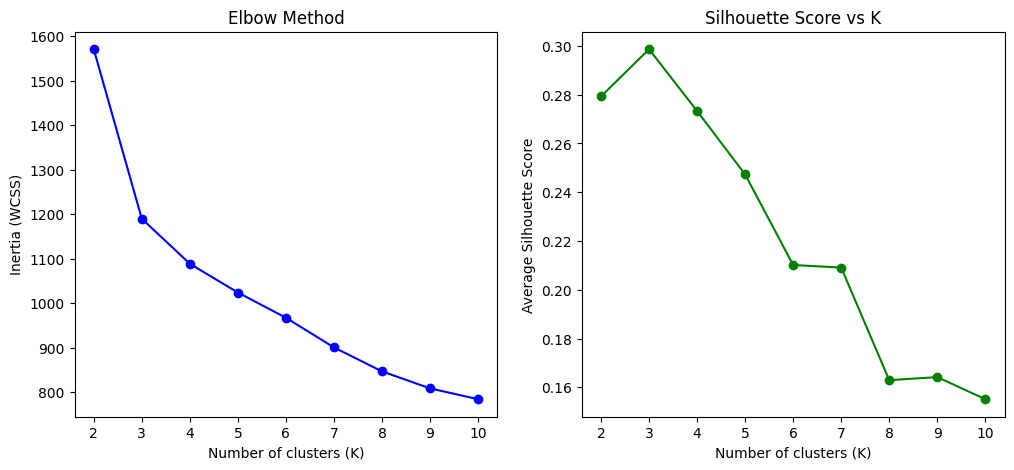

Optimal K selected: 3
Inertia (WCSS): 1189.6391379398015
Average Silhouette Score: 0.299
Per-cluster silhouette scores: [np.float64(0.18756295019355984), np.float64(0.36655113747193774), np.float64(0.35932935267940497)]
Cluster sizes: 0    65
1    51
2    62
Name: count, dtype: int64

Cluster Centers in PCA space:
       PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0 -0.036957 -1.772239  0.186139  0.080240  0.070878 -0.129806 -0.002327   
1 -2.720036  1.125651 -0.239093  0.062457  0.073676 -0.099925 -0.060383   
2  2.276194  0.932054  0.001528 -0.135498 -0.134912  0.218283  0.052110   

       PCA8      PCA9     PCA10  
0  0.018015 -0.032251 -0.023004  
1  0.007388 -0.020027 -0.061468  
2 -0.024964  0.050286  0.074679  


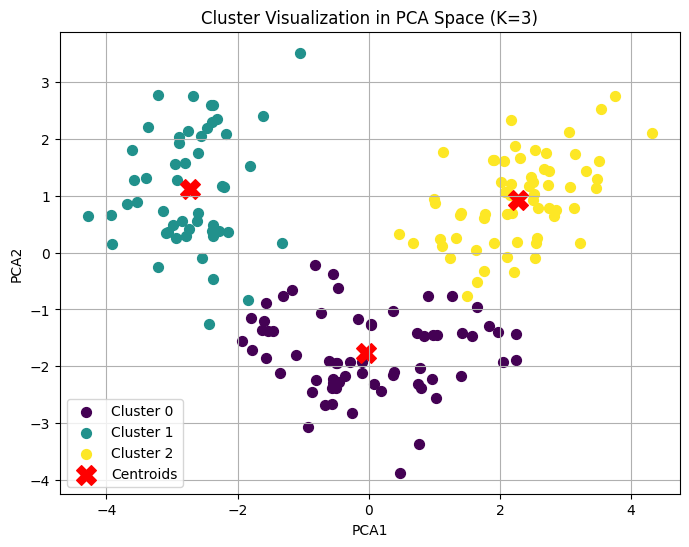

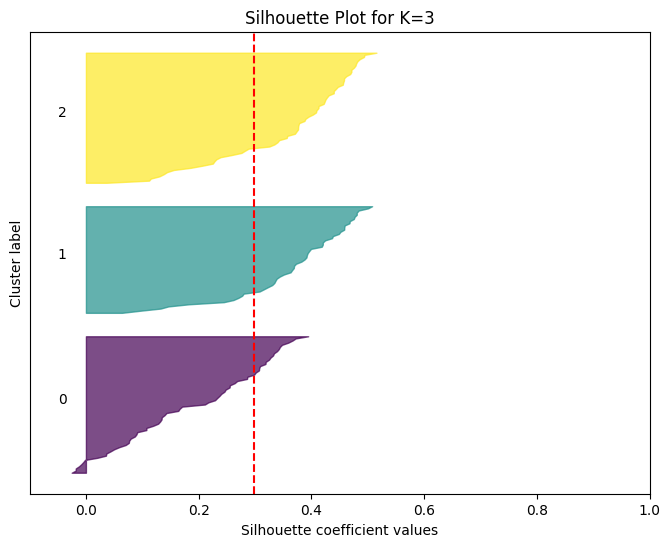

In [32]:
# ============================
# Find optimal K
# ============================
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# ============================
# Plot Elbow and Silhouette
# ============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, 'o-', color='blue')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, 'o-', color='green')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs K")

plt.show()

# ============================
# Fit KMeans with chosen K
# ============================
optimal_k = 3
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans_opt.fit_predict(X_pca)

# ============================
# Cluster diagnostics
# ============================
print(f"Optimal K selected: {optimal_k}")
print(f"Inertia (WCSS): {kmeans_opt.inertia_}")
avg_silhouette = silhouette_score(X_pca, labels)
print(f"Average Silhouette Score: {avg_silhouette:.3f}")

sample_silhouette_values = silhouette_samples(X_pca, labels)
per_cluster_silhouette = [
    sample_silhouette_values[labels==i].mean() for i in range(optimal_k)
]
print("Per-cluster silhouette scores:", per_cluster_silhouette)

cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("Cluster sizes:", cluster_sizes)

print("\nCluster Centers in PCA space:")
print(pd.DataFrame(kmeans_opt.cluster_centers_, columns=[f"PCA{i+1}" for i in range(X_pca.shape[1])]))

# ================================
# 2D Cluster Visualization (PCA1 vs PCA2)
# ================================
plt.figure(figsize=(8,6))
colors = cm.get_cmap("viridis", optimal_k)

for i in range(optimal_k):
    plt.scatter(
        X_pca[labels==i, 0], X_pca[labels==i, 1],
        s=50, color=colors(i), label=f"Cluster {i}"
    )

plt.scatter(
    kmeans_opt.cluster_centers_[:, 0],
    kmeans_opt.cluster_centers_[:, 1],
    s=200, c='red', marker='X', label='Centroids'
)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title(f"Cluster Visualization in PCA Space (K={optimal_k})")
plt.legend()
plt.grid(True)
plt.show()


# ================================
# Silhouette Plot
# ================================
from sklearn.metrics import silhouette_samples

sample_silhouette_values = silhouette_samples(X_pca, labels)

fig, ax = plt.subplots(figsize=(8,6))

y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = colors(i)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    
    ax.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_title(f"Silhouette Plot for K={optimal_k}")
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
plt.show()

The K-Means baseline above actually did really well given the data.
 - 3 clusters as optimal, but the average silhouette score (0.299) indicates only moderate separation, with one cluster 0 showing weak cohesion.
 - Cluster sizes are balanced (65, 51, 62), and cluster centers in PCA space indicate a clear separation largely along PCA1 and PCA2, with Cluster 1 strongly negative on PCA1 and Cluster 2 strongly  positive.
 - The baseline results suggest that while K-means captures broad structure in the data, the quality of clustering is limited, indicating room for improvement using more robust methods such as K-Medoids.

# Model Execution and Analysis

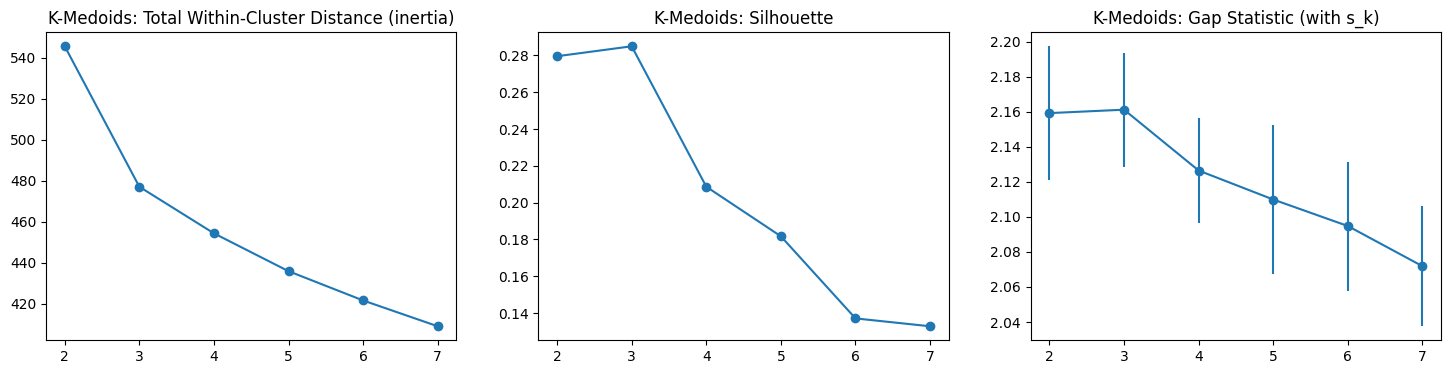

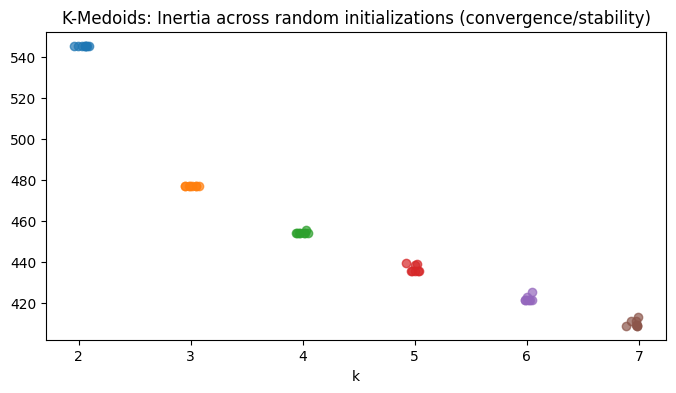

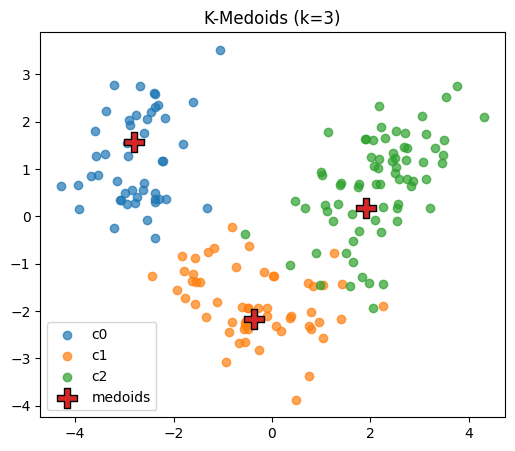

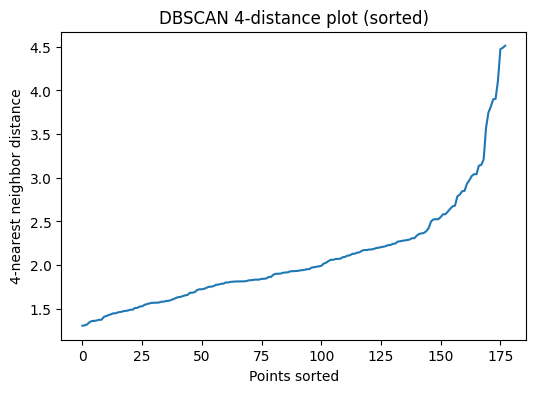

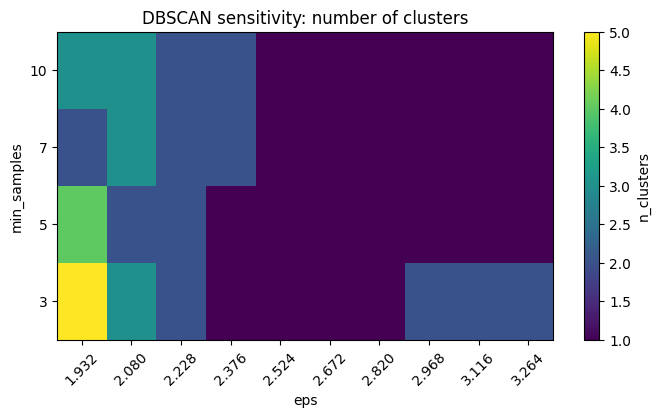

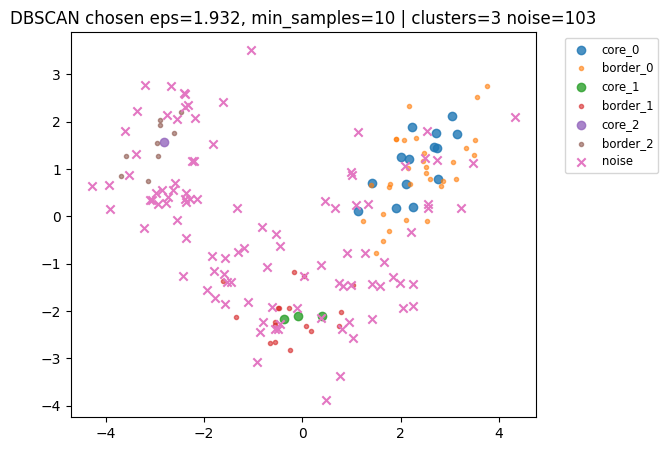

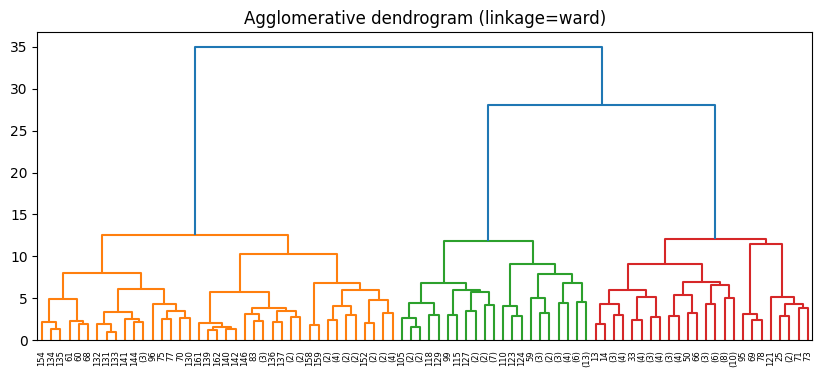

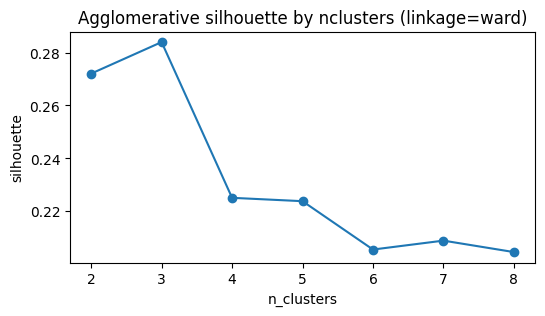

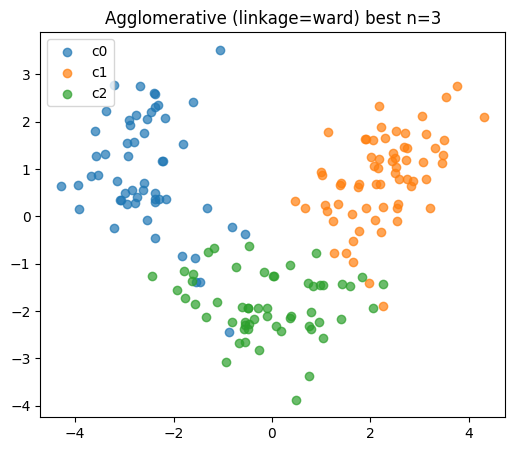

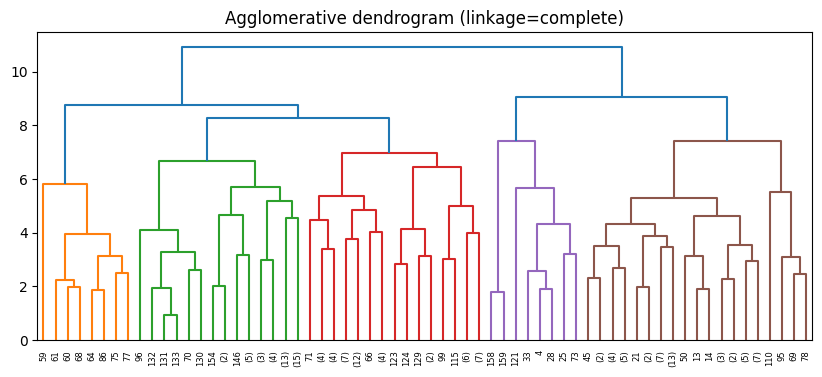

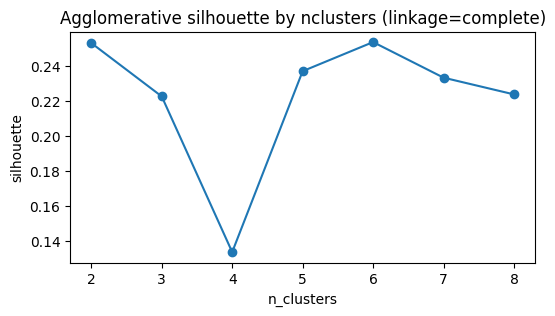

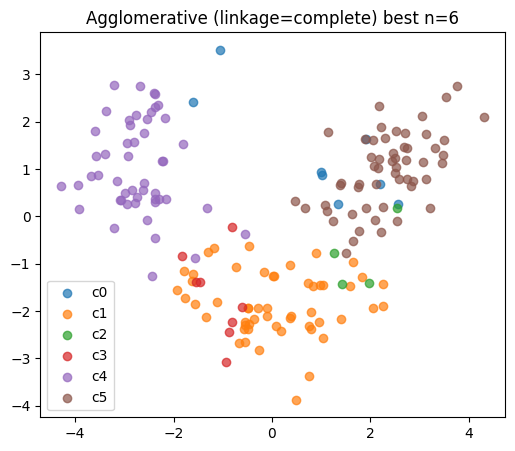

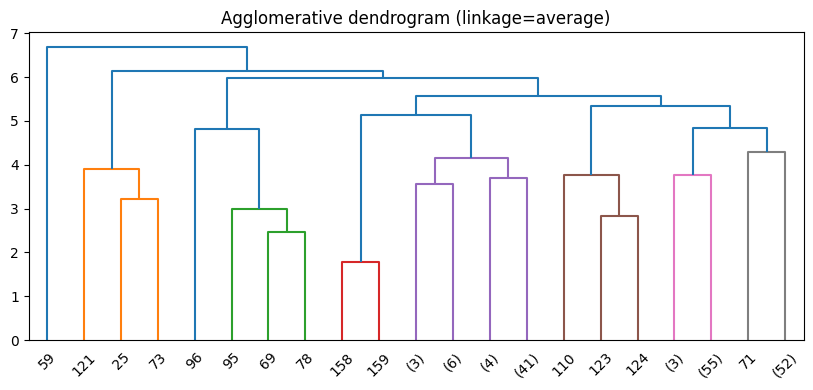

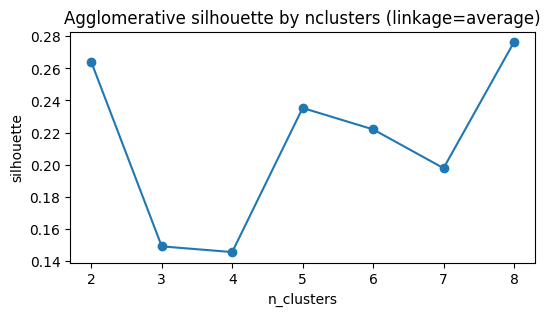

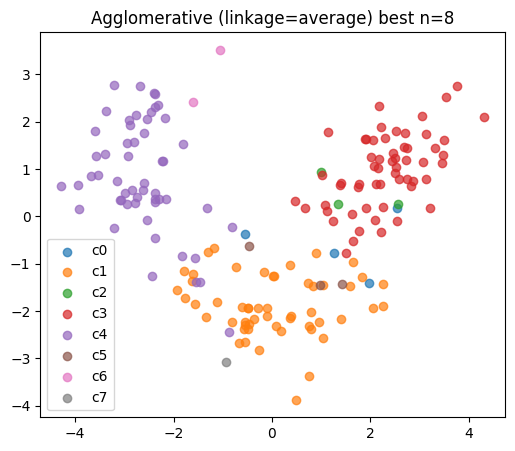

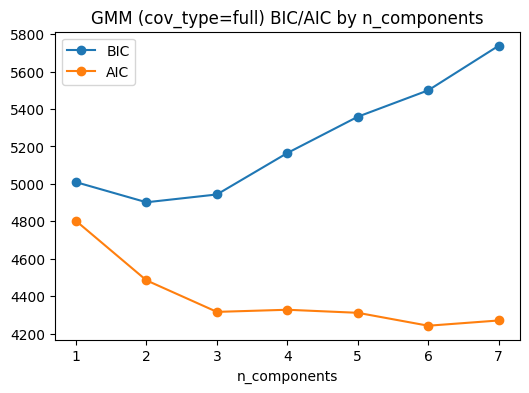

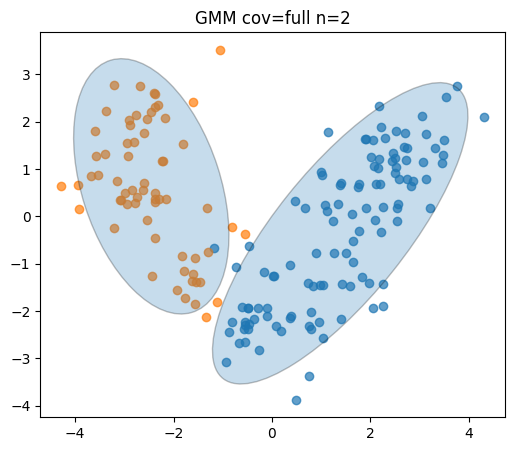

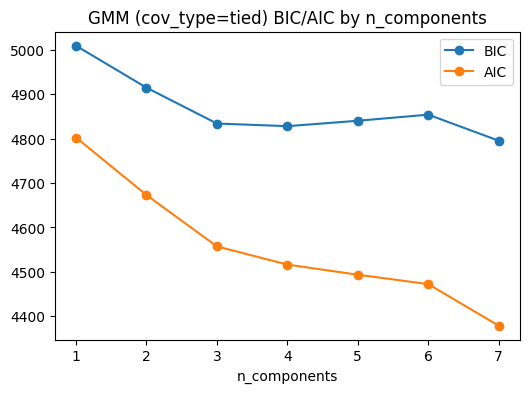

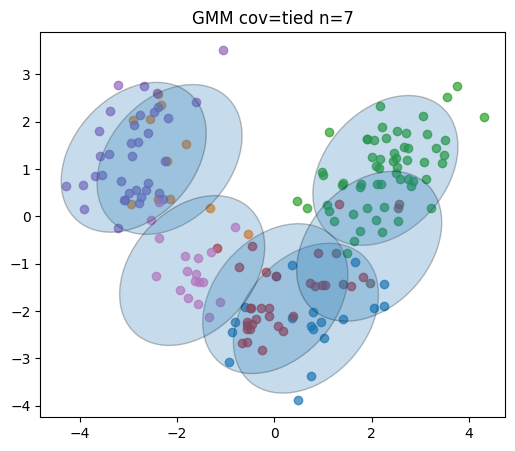

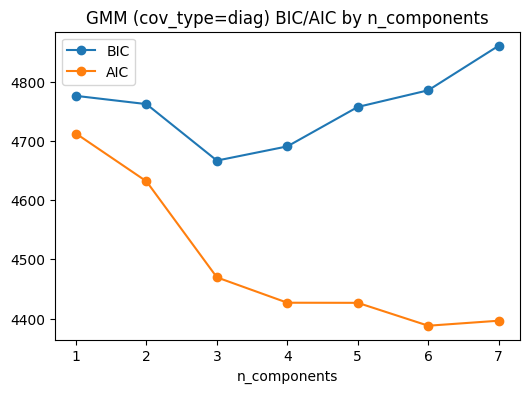

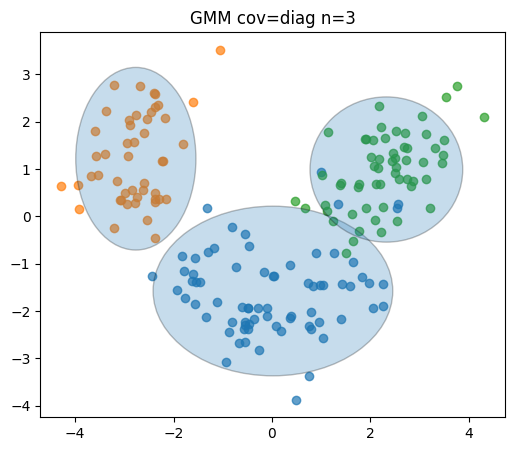

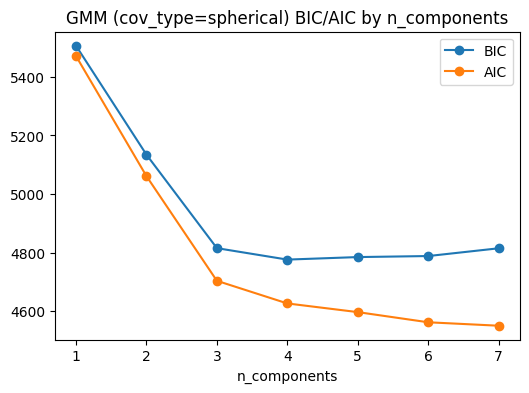

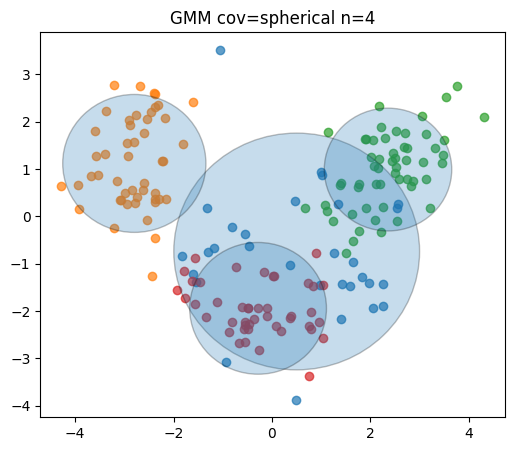

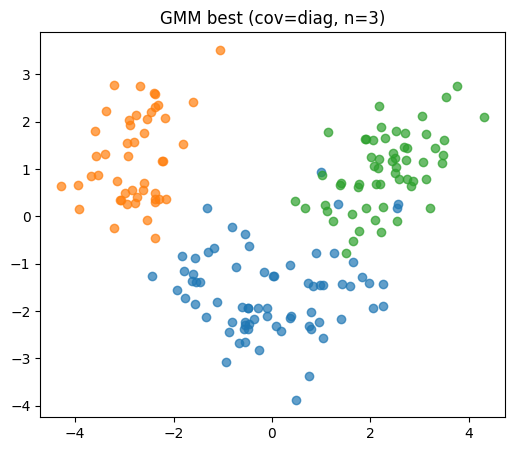

Best GMM overall (by BIC): {'covariance_type': 'diag', 'n_components': 3, 'bic': np.float64(4666.8224974306395), 'aic': np.float64(4469.55191731253)}
Cluster probability samples (first 5 rows):
[[2.22130918e-04 5.03327879e-22 9.99777869e-01]
 [2.69401431e-02 4.11205526e-16 9.73059857e-01]
 [4.17530214e-04 6.85641517e-18 9.99582470e-01]
 [4.89201322e-07 1.22976309e-24 9.99999511e-01]
 [1.03500873e-01 1.15906843e-08 8.96499116e-01]]


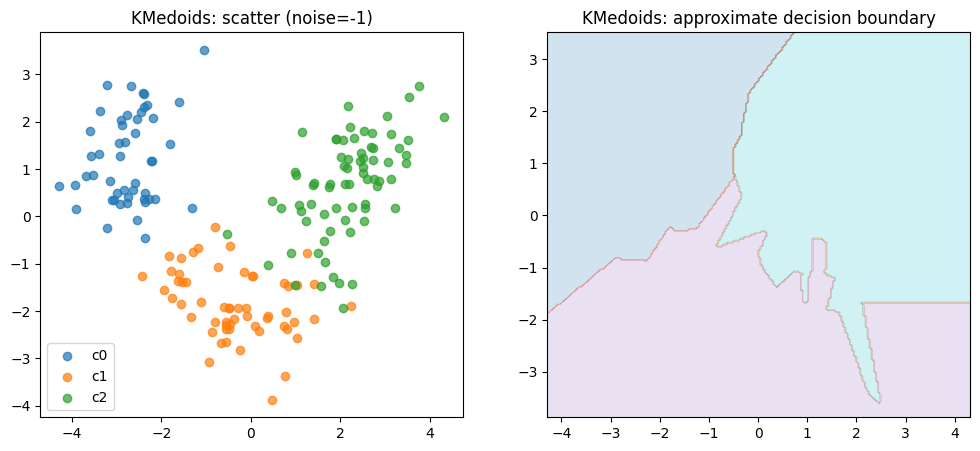

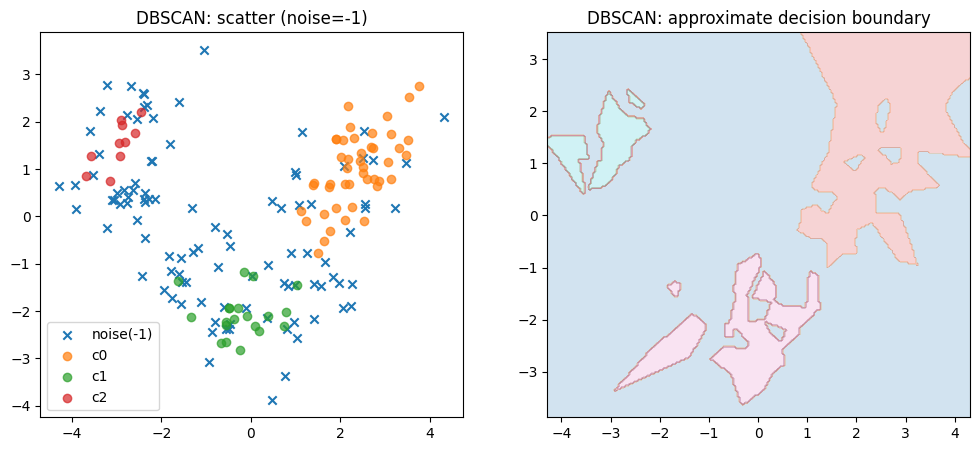

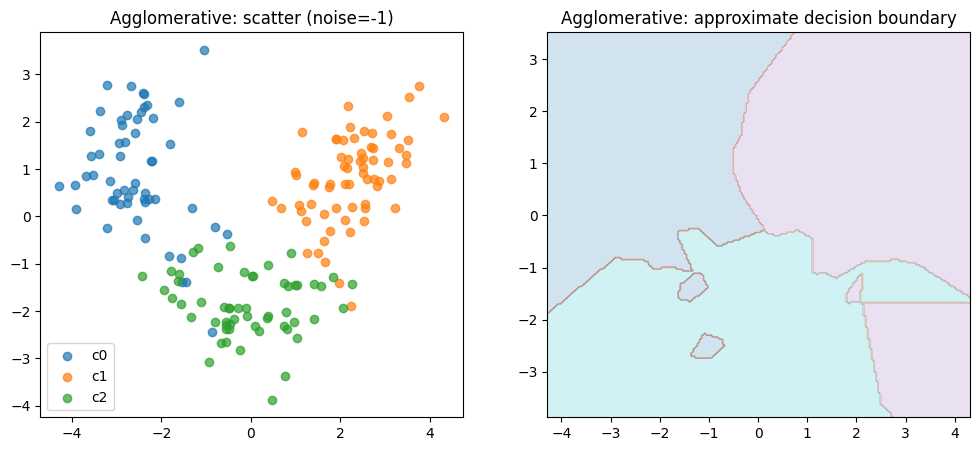

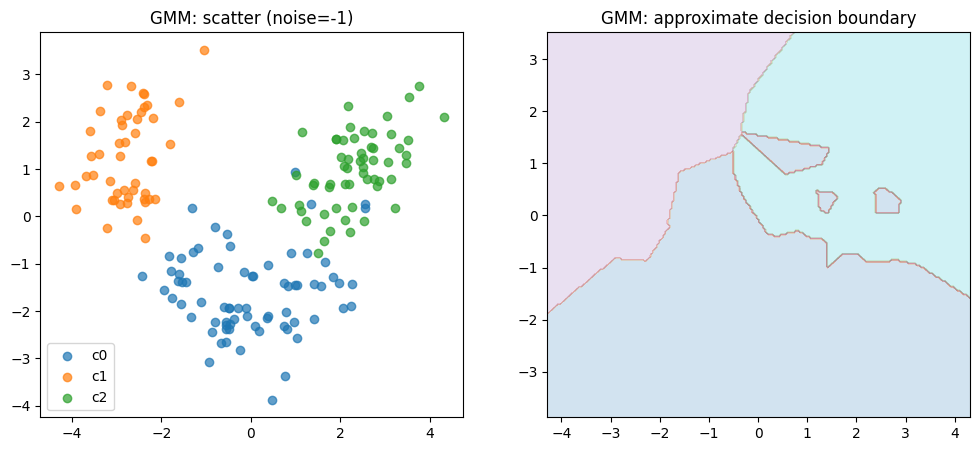

In [33]:
warnings.filterwarnings("ignore", category=UserWarning)

def ensure_2d_for_plot(X):
    if X.shape[1] >= 2:
        return X[:, :2]
    else:
        return np.hstack([X, np.zeros((X.shape[0], 1))])


def plot_2d_scatter(X2, labels, title="", ax=None, show_legend=False, noise_label=-1):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    unique = np.unique(labels)
    for lab in unique:
        mask = labels == lab
        if lab == noise_label:
            ax.scatter(X2[mask, 0], X2[mask, 1], marker="x", label=f"noise({lab})")
        else:
            ax.scatter(X2[mask, 0], X2[mask, 1], label=f"c{lab}", alpha=0.7)
    ax.set_title(title)
    if show_legend:
        ax.legend()
    return ax


def plot_decision_boundary(X2, label_func, ax=None, title="Decision boundary", grid_res=200, cmap="tab10"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    x_min, x_max = X2[:, 0].min() - 1e-3, X2[:, 0].max() + 1e-3
    y_min, y_max = X2[:, 1].min() - 1e-3, X2[:, 1].max() + 1e-3
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_res),
                         np.linspace(y_min, y_max, grid_res))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = label_func(grid)
    zz = zz.reshape(xx.shape)
    ax.contourf(xx, yy, zz, alpha=0.2, cmap=plt.get_cmap(cmap))
    ax.set_title(title)
    return ax


def draw_ellipse(position, covariance, ax, n_std=2.0, **kwargs):
    if covariance.shape != (2, 2):
        return
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvals)
    ell = Ellipse(xy=position, width=width, height=height, angle=angle, alpha=0.25, **kwargs)
    ax.add_patch(ell)


# -------------------------
# K-Medoids Analysis
# -------------------------
def kmedoids_analysis(X, K_range=range(2, 10), gap_refs=10, random_inits=5, plot=True):
    n = X.shape[0]
    dist_matrix = calculate_distance_matrix(X)
    inertias = []
    silhouettes = []
    models = {}
    inertia_history = {}
    medoids_history = {}

    for k in K_range:
        run_inertias = []
        run_labels = []
        run_medoids = []
        for init_i in range(random_inits):
            if init_i == 0:
                initial_medoids = list(range(k))
            else:
                initial_medoids = list(np.random.choice(range(n), size=k, replace=False))

            km = kmedoids(dist_matrix, initial_medoids, data_type="distance_matrix")
            km.process()
            clusters = km.get_clusters()
            medoids = km.get_medoids()
            labels = np.zeros(n, dtype=int)
            total_distance = 0
            for i_c, cluster in enumerate(clusters):
                labels[cluster] = i_c
                medoid_idx = medoids[i_c]
                for p in cluster:
                    total_distance += dist_matrix[medoid_idx][p]

            run_inertias.append(total_distance)
            run_labels.append(labels)
            run_medoids.append(medoids)

        best_idx = int(np.argmin(run_inertias))
        inertias.append(run_inertias[best_idx])
        try:
            silhouettes.append(silhouette_score(X, run_labels[best_idx]) if len(np.unique(run_labels[best_idx])) > 1 else np.nan)
        except Exception:
            silhouettes.append(np.nan)
        models[int(k)] = run_labels[best_idx]
        inertia_history[int(k)] = run_inertias
        medoids_history[int(k)] = run_medoids

    def _Wk_for_labels(X_sample, labels):
        total = 0.0
        for lab in np.unique(labels):
            members = X_sample[labels == lab]
            if members.shape[0] <= 1:
                continue
            centroid = members.mean(axis=0)
            total += ((members - centroid) ** 2).sum()
        return total

    gaps = []
    sk = []
    rng = np.random.RandomState(42)
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)

    for idx_k, k in enumerate(K_range):
        Wk = inertias[idx_k]
        logWk = np.log(Wk + 1e-9)

        ref_Wks = []
        for b in range(gap_refs):
            Xb = rng.uniform(X_min, X_max, size=X.shape)
            dmat_b = calculate_distance_matrix(Xb)
            init_med = list(rng.choice(range(n), size=k, replace=False))
            km_b = kmedoids(dmat_b, init_med, data_type="distance_matrix")
            km_b.process()
            clusters_b = km_b.get_clusters()
            labels_b = np.zeros(n, dtype=int)
            for i_c, cluster in enumerate(clusters_b):
                labels_b[cluster] = i_c
            Wb = _Wk_for_labels(Xb, labels_b)
            ref_Wks.append(np.log(Wb + 1e-9))
        ref_Wks = np.array(ref_Wks)
        gap = ref_Wks.mean() - logWk
        sdk = np.sqrt(((ref_Wks - ref_Wks.mean()) ** 2).sum() / (gap_refs - 1)) * np.sqrt(1 + 1.0 / gap_refs)
        gaps.append(gap)
        sk.append(sdk)

    best_k = K_range[int(np.argmax(silhouettes))] if any(~np.isnan(silhouettes)) else K_range[0]
    results = {
        "K_range": list(K_range),
        "inertias": inertias,
        "silhouettes": silhouettes,
        "gaps": gaps,
        "gap_sk": sk,
        "best_k_by_silhouette": int(best_k),
        "medoids_labels": models[int(best_k)],
        "medoids_indices": medoids_history[int(best_k)][0] if medoids_history[int(best_k)] else None,
        "inertia_history": inertia_history,
        "medoids_history": medoids_history,
    }

    if plot:
        X2 = ensure_2d_for_plot(X)
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        axs[0].plot(list(K_range), inertias, marker="o")
        axs[0].set_title("K-Medoids: Total Within-Cluster Distance (inertia)")
        axs[1].plot(list(K_range), silhouettes, marker="o")
        axs[1].set_title("K-Medoids: Silhouette")
        axs[2].errorbar(list(K_range), gaps, yerr=sk, marker="o")
        axs[2].set_title("K-Medoids: Gap Statistic (with s_k)")
        plt.show()

        fig, ax = plt.subplots(figsize=(8, 4))
        jitter = 0.05
        for i_k, k in enumerate(K_range):
            runs = inertia_history[int(k)]
            xs = np.full(len(runs), i_k) + np.random.normal(0, jitter, size=len(runs))
            ax.scatter(xs, runs, alpha=0.7)
        ax.set_xticks(range(len(K_range)))
        ax.set_xticklabels(list(K_range))
        ax.set_xlabel("k")
        ax.set_title("K-Medoids: Inertia across random initializations (convergence/stability)")
        plt.show()

        fig, ax = plt.subplots(figsize=(6, 5))
        plot_2d_scatter(X2, results["medoids_labels"], title=f"K-Medoids (k={best_k})", ax=ax)
        med_idxs = results["medoids_indices"]
        if med_idxs:
            ax.scatter(X2[med_idxs, 0], X2[med_idxs, 1], marker="P", s=200, edgecolor="k", label="medoids")
            ax.legend()
        plt.show()

    return results


# -------------------------
# DBSCAN Analysis
# -------------------------
def dbscan_analysis(X, eps_grid=None, min_samples_grid=None, k_for_kdist=4, plot=True):
    X2 = ensure_2d_for_plot(X)
    n = X.shape[0]

    neigh = NearestNeighbors(n_neighbors=k_for_kdist).fit(X)
    dists, _ = neigh.kneighbors(X)
    kdist = np.sort(dists[:, -1])

    if eps_grid is None:
        eps_grid = np.linspace(np.percentile(kdist, 50), np.percentile(kdist, 95), 10)
    if min_samples_grid is None:
        min_samples_grid = [3, 5, 7, 10]

    results_table = []
    models = {}
    for ms in min_samples_grid:
        for eps in eps_grid:
            db = DBSCAN(eps=eps, min_samples=ms).fit(X)
            labels = db.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)
            core_count = len(getattr(db, "core_sample_indices_", []))
            border_count = n - core_count - n_noise
            sil = np.nan
            try:
                mask = labels != -1
                if n_clusters >= 2:
                    sil = silhouette_score(X[mask], labels[mask])
            except Exception:
                sil = np.nan
            results_table.append({"eps": eps, "min_samples": ms, "n_clusters": n_clusters, "n_noise": int(n_noise),
                                  "core": int(core_count), "border": int(border_count), "silhouette_non_noise": sil})
            models[(eps, ms)] = labels

    df = results_table
    best = max(df, key=lambda r: (r["silhouette_non_noise"] if r["silhouette_non_noise"] is not None else -999,
                                  r["n_clusters"]))
    chosen_labels = models[(best["eps"], best["min_samples"])]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(kdist)
        plt.title(f"DBSCAN {k_for_kdist}-distance plot (sorted)")
        plt.xlabel("Points sorted")
        plt.ylabel(f"{k_for_kdist}-nearest neighbor distance")
        plt.show()

        eps_vals = sorted(set([r["eps"] for r in df]))
        ms_vals = sorted(set([r["min_samples"] for r in df]))
        mat = np.zeros((len(ms_vals), len(eps_vals)))
        for i, ms in enumerate(ms_vals):
            for j, eps in enumerate(eps_vals):
                entry = next(r for r in df if r["eps"] == eps and r["min_samples"] == ms)
                mat[i, j] = entry["n_clusters"]
        fig, ax = plt.subplots(figsize=(8, 4))
        im = ax.imshow(mat, aspect="auto", origin="lower")
        ax.set_xticks(range(len(eps_vals)))
        ax.set_xticklabels([f"{e:.3f}" for e in eps_vals], rotation=45)
        ax.set_yticks(range(len(ms_vals)))
        ax.set_yticklabels(ms_vals)
        ax.set_xlabel("eps")
        ax.set_ylabel("min_samples")
        ax.set_title("DBSCAN sensitivity: number of clusters")
        fig.colorbar(im, ax=ax, label="n_clusters")
        plt.show()

        db_chosen = DBSCAN(eps=best["eps"], min_samples=best["min_samples"]).fit(X)
        labels = db_chosen.labels_
        core_samples = np.zeros(n, dtype=bool)
        core_samples[getattr(db_chosen, "core_sample_indices_", [])] = True
        fig, ax = plt.subplots(figsize=(6, 5))
        unique_labels = set(labels)
        for lab in unique_labels:
            mask = labels == lab
            if lab == -1:
                ax.scatter(X2[mask, 0], X2[mask, 1], marker="x", label="noise")
            else:
                ax.scatter(X2[mask & core_samples, 0], X2[mask & core_samples, 1], marker="o", label=f"core_{lab}", alpha=0.8)
                ax.scatter(X2[mask & ~core_samples, 0], X2[mask & ~core_samples, 1], marker=".", label=f"border_{lab}", alpha=0.6)
        ax.set_title(f"DBSCAN chosen eps={best['eps']:.3f}, min_samples={best['min_samples']} | clusters={best['n_clusters']} noise={best['n_noise']}")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
        plt.show()

    return {"results_table": results_table, "best_params": best, "chosen_labels": chosen_labels}


# -------------------------
# Agglomerative Clustering Analysis
# -------------------------
def agglomerative_analysis(X, linkage_methods=("ward", "complete", "average", "single"), max_clusters=8, plot=True):
    results = {}
    X2 = ensure_2d_for_plot(X)
    for method in linkage_methods:
        Z = linkage(X, method=method)
        silhouettes = {}
        labels_store = {}
        for n_clusters in range(2, max_clusters + 1):
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=method if method in ("complete", "average", "single") else "ward")
            labels = agg.fit_predict(X)
            try:
                sil = silhouette_score(X, labels)
            except Exception:
                sil = np.nan
            silhouettes[n_clusters] = sil
            labels_store[n_clusters] = labels
        best_n = max(silhouettes.keys(), key=lambda k: (silhouettes[k] if not np.isnan(silhouettes[k]) else -999))
        results[method] = {"Z": Z, "silhouettes": silhouettes, "best_n": best_n, "labels": labels_store[best_n]}

        if plot:
            plt.figure(figsize=(10, 4))
            dendrogram(Z, truncate_mode="level", p=6)
            plt.title(f"Agglomerative dendrogram (linkage={method})")
            plt.show()

            ks = sorted(silhouettes.keys())
            vals = [silhouettes[k] for k in ks]
            plt.figure(figsize=(6, 3))
            plt.plot(ks, vals, marker="o")
            plt.title(f"Agglomerative silhouette by nclusters (linkage={method})")
            plt.xlabel("n_clusters")
            plt.ylabel("silhouette")
            plt.show()

            fig, ax = plt.subplots(figsize=(6, 5))
            plot_2d_scatter(X2, results[method]["labels"], title=f"Agglomerative (linkage={method}) best n={best_n}", ax=ax, show_legend=True)
            plt.show()

    return results


# -------------------------
# Gaussian Mixture Models Analysis
# -------------------------
def gmm_analysis(X, n_components_range=range(1, 10), covariance_types=("full", "tied", "diag", "spherical"), plot=True):
    X2 = ensure_2d_for_plot(X)
    results = {}
    all_records = []
    best_models = {}

    for cov_type in covariance_types:
        bics = []
        aics = []
        models = {}
        for n in n_components_range:
            gm = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)
            gm.fit(X)
            bics.append(gm.bic(X))
            aics.append(gm.aic(X))
            models[n] = gm
            all_records.append({"covariance_type": cov_type, "n_components": n, "bic": bics[-1], "aic": aics[-1]})
        best_n = int(n_components_range[np.argmin(bics)])
        best_models[cov_type] = {"best_n": best_n, "model": models[best_n], "bics": bics, "aics": aics}

        if plot:
            plt.figure(figsize=(6, 4))
            plt.plot(list(n_components_range), bics, marker="o", label="BIC")
            plt.plot(list(n_components_range), aics, marker="o", label="AIC")
            plt.title(f"GMM (cov_type={cov_type}) BIC/AIC by n_components")
            plt.xlabel("n_components")
            plt.legend()
            plt.show()

            gm = models[best_n]
            labels = gm.predict(X)
            probs = gm.predict_proba(X)
            fig, ax = plt.subplots(figsize=(6, 5))
            plot_2d_scatter(X2, labels, title=f"GMM cov={cov_type} n={best_n}", ax=ax)
            covs = gm.covariances_
            means = gm.means_
            for comp in range(best_n):
                mean2 = means[comp, :2]
                if cov_type == "tied":
                    cov2 = covs[:2, :2]
                elif cov_type == "spherical":
                    cov2 = np.eye(2) * covs[comp]
                elif cov_type == "diag":
                    cov2 = np.diag(covs[comp][:2])
                else:  # full
                    cov2 = covs[comp][:2, :2]
                draw_ellipse(mean2, cov2, ax, edgecolor="k")
            plt.show()

    all_records_sorted = sorted(all_records, key=lambda r: r["bic"])
    best_overall = all_records_sorted[0]
    best_gm = best_models[best_overall["covariance_type"]]["model"]

    probs = best_gm.predict_proba(X)

    results["best_overall"] = best_overall
    results["best_model"] = best_gm
    results["best_probs"] = probs
    results["per_covariance"] = best_models
    results["all_records"] = all_records

    if plot:
        labels = best_gm.predict(X)
        fig, ax = plt.subplots(figsize=(6, 5))
        plot_2d_scatter(X2, labels, title=f"GMM best (cov={best_overall['covariance_type']}, n={best_overall['n_components']})", ax=ax)
        plt.show()

        print("Best GMM overall (by BIC):", best_overall)
        print("Cluster probability samples (first 5 rows):")
        print(probs[:5])

    return results


# -------------------------
# Universal Visualization Utility
# -------------------------
def universal_cluster_viz(X, label_dict, mesh_resolution=300):
    X2 = ensure_2d_for_plot(X)

    for name, labels in label_dict.items():
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plot_2d_scatter(X2, labels, title=f"{name}: scatter (noise=-1)", ax=axs[0], show_legend=True)
        def label_func(grid_pts, known_X=X2, known_labels=labels):
            d = cdist(grid_pts, known_X)
            idx = np.argmin(d, axis=1)
            return known_labels[idx]

        axs[1] = plot_decision_boundary(X2, label_func, ax=axs[1], title=f"{name}: approximate decision boundary")
        plt.show()


# -------------------------
# Run the Clustering Models
# -------------------------
results_kmed = kmedoids_analysis(X_pca, K_range=range(2, 8), gap_refs=10, random_inits=8)
results_db = dbscan_analysis(X_pca, k_for_kdist=4)
results_agg = agglomerative_analysis(X_pca, linkage_methods=("ward", "complete", "average"), max_clusters=8)
results_gmm = gmm_analysis(X_pca, n_components_range=range(1, 8), covariance_types=("full", "tied", "diag", "spherical"))
universal_cluster_viz(X_pca, {
    "KMedoids": results_kmed["medoids_labels"],
    "DBSCAN": results_db["chosen_labels"],
    "Agglomerative": results_agg["ward"]["labels"],
    "GMM": results_gmm["best_model"].predict(X_pca)
})


# Model Comparisons


=== Internal validation metrics ===
               silhouette  davies_bouldin  calinski_harabasz  inertia  \
algorithm                                                               
KMedoids           0.2850          1.3710              72.61  1216.16   
DBSCAN             0.4660          0.7857              67.46   234.45   
Agglomerative      0.2840          1.3441              72.14  1219.74   
GMM                0.2932          1.3584              73.35  1210.59   

               n_clusters  n_noise  train_time_s  
algorithm                                         
KMedoids                3        0           NaN  
DBSCAN                  3      103           NaN  
Agglomerative           3        0           NaN  
GMM                     3        0           NaN  


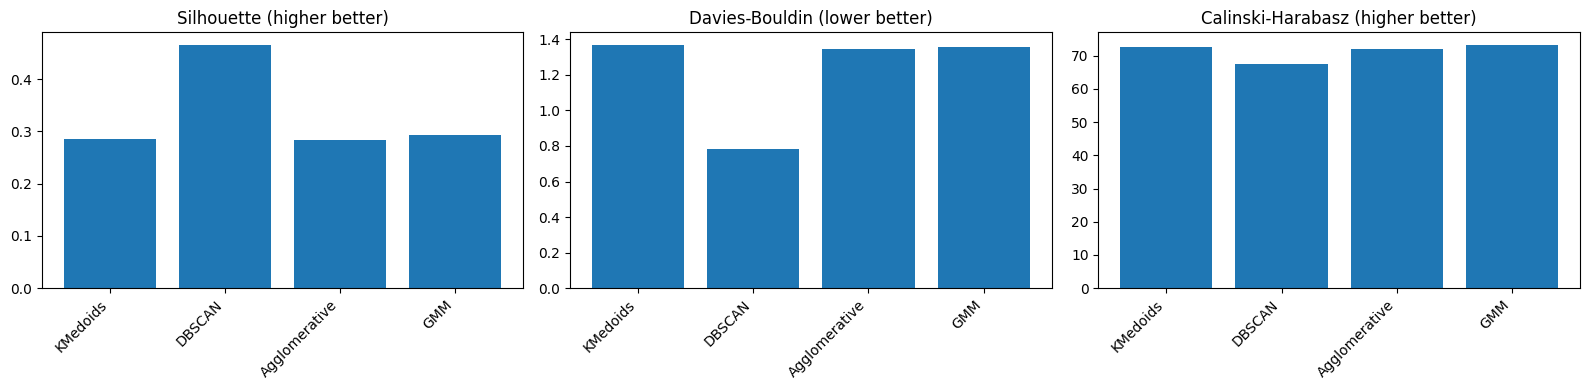

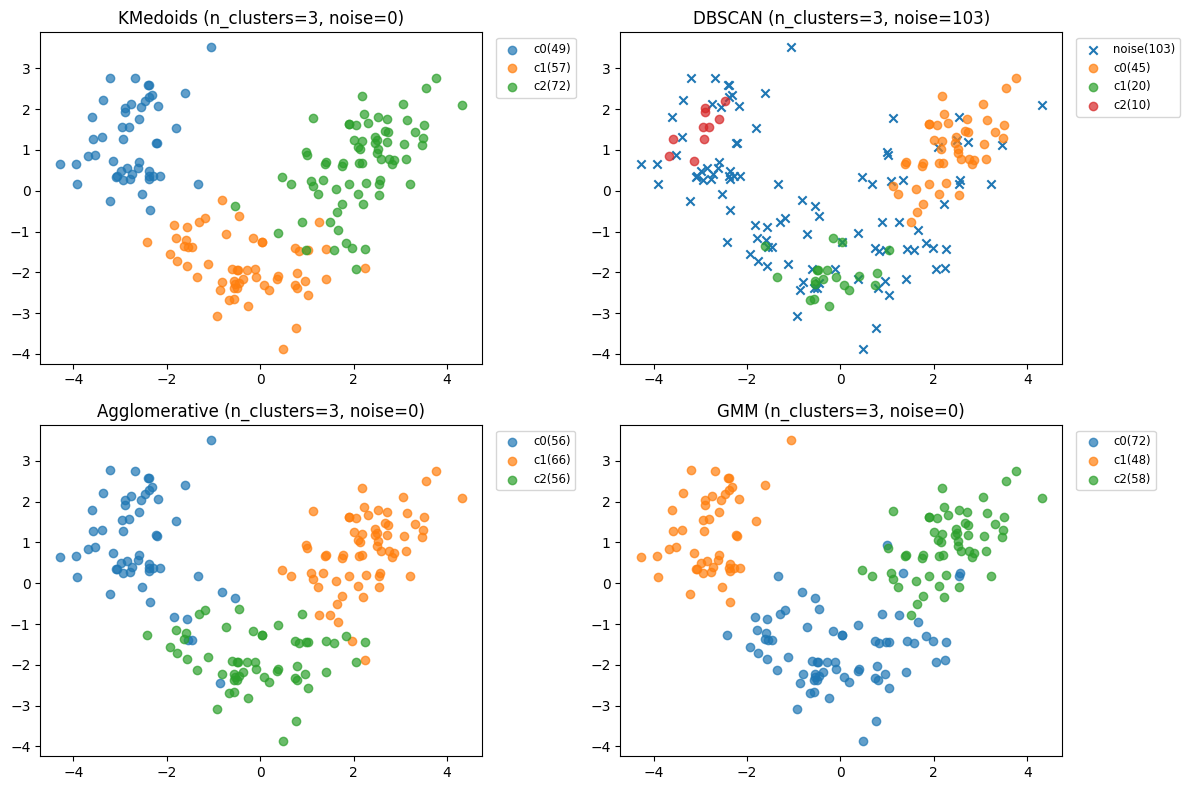

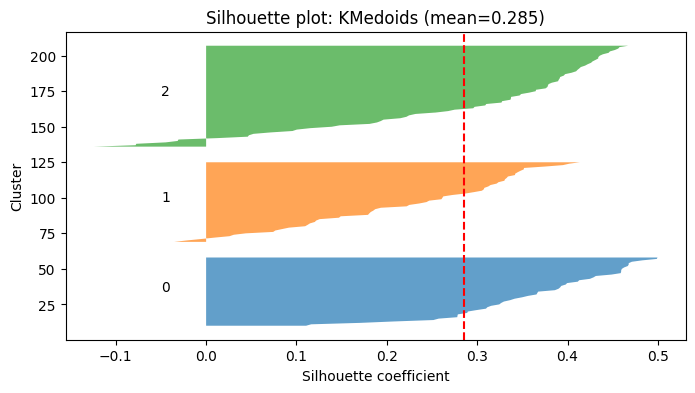

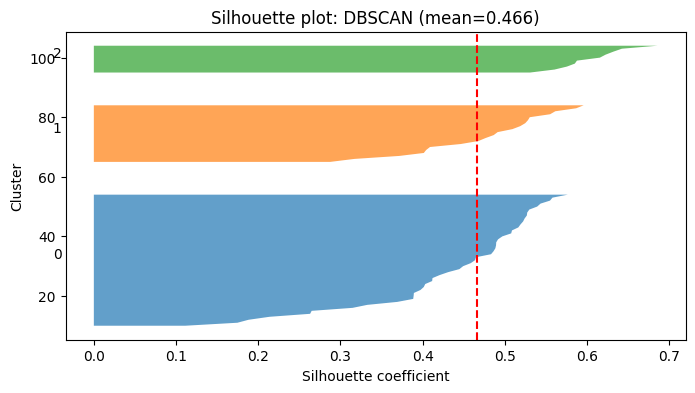

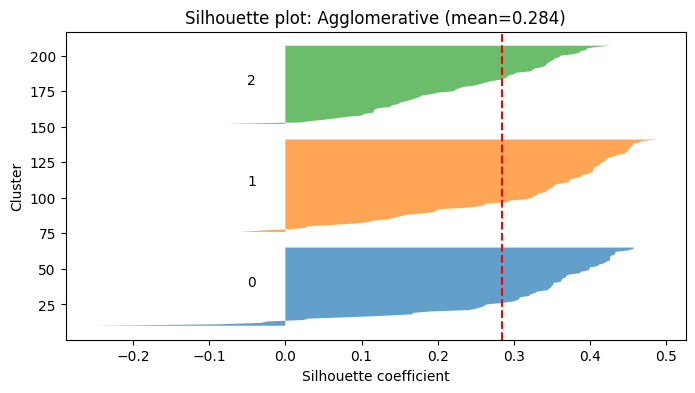

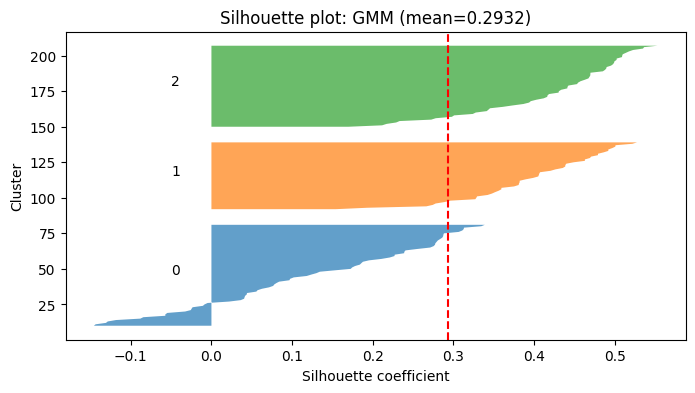

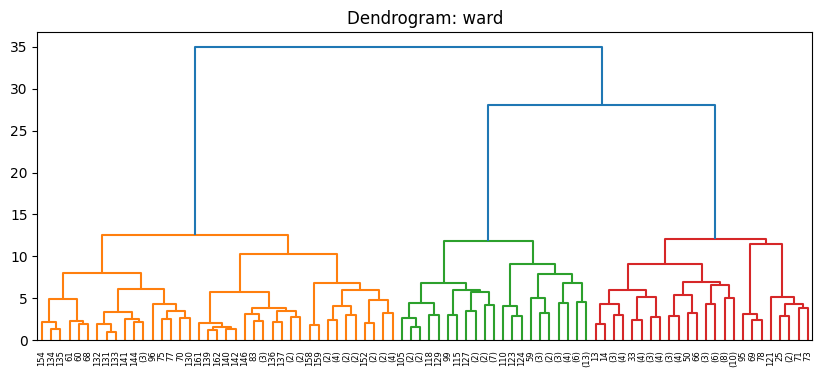

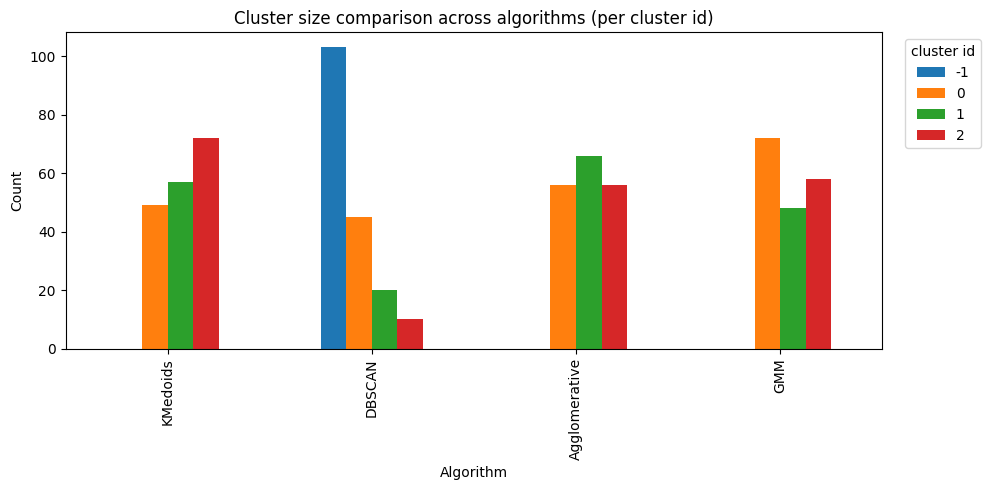

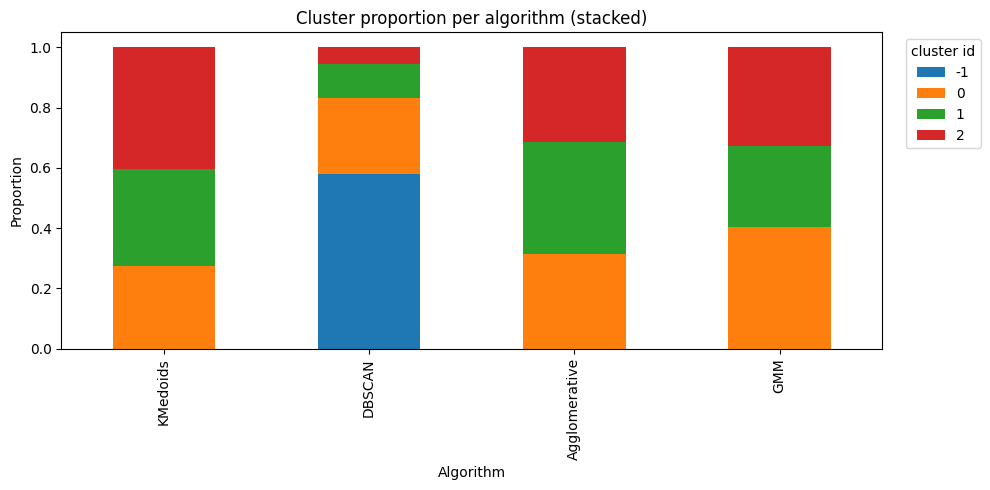

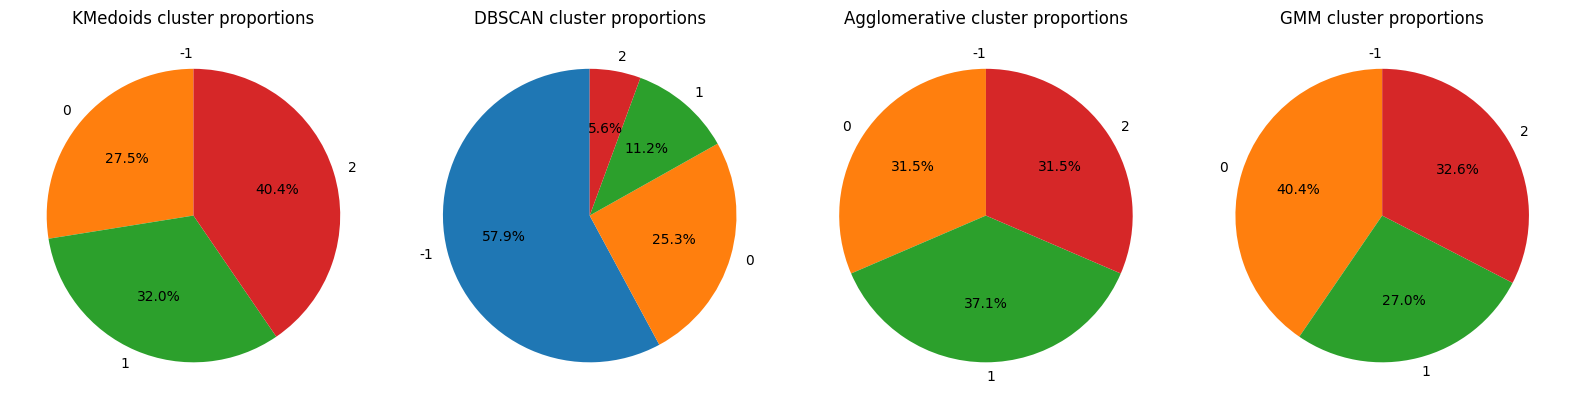

In [34]:
warnings.filterwarnings("ignore")

def ensure_2d_for_plot(X):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if X.shape[1] >= 2:
        return X[:, :2]
    else:
        return np.hstack([X, np.zeros((X.shape[0], 1))])


def compute_inertia_from_centers(X, labels):
    inertia = 0.0
    unique = [l for l in np.unique(labels) if l != -1]
    for lab in unique:
        members = X[labels == lab]
        if members.shape[0] == 0:
            continue
        centroid = members.mean(axis=0)
        inertia += ((members - centroid) ** 2).sum()
    return inertia


def compute_inertia_from_medoids(dist_matrix, medoid_indices, labels):
    total = 0.0
    medoid_to_cluster = {}
    for m in medoid_indices:
        medoid_to_cluster[m] = labels[m] if len(labels) > m else None
    for m in medoid_indices:
        cluster_id = medoid_to_cluster.get(m, None)
        if cluster_id is None:
            continue
        members_idx = np.where(labels == cluster_id)[0]
        for idx in members_idx:
            total += dist_matrix[m][idx]
    return total


def clustering_comparison(
    X,
    label_dict,
    train_time_dict=None,
    medoids_indices=None,
    distance_matrix=None,
    linkage_Z=None,
    true_labels=None,
    plot=True,
):
    X = np.asarray(X)
    X2 = ensure_2d_for_plot(X)
    n = X.shape[0]
    algorithms = list(label_dict.keys())
    results = []

    for algo in algorithms:
        labels = np.asarray(label_dict[algo])
        unique_labels = set(labels)
        n_noise = int(np.sum(labels == -1))
        n_clusters = len(unique_labels - {-1})

        silhouette = np.nan
        davies = np.nan
        calinski = np.nan

        try:
            if n_clusters >= 2:
                if -1 in unique_labels:
                    mask = labels != -1
                    if len(np.unique(labels[mask])) >= 2:
                        silhouette = silhouette_score(X[mask], labels[mask])
                else:
                    silhouette = silhouette_score(X, labels)
        except Exception:
            silhouette = np.nan

        try:
            if n_clusters >= 2:
                davies = davies_bouldin_score(X[labels != -1] if -1 in unique_labels else X, labels[labels != -1] if -1 in unique_labels else labels)
        except Exception:
            davies = np.nan

        try:
            if n_clusters >= 2:
                calinski = calinski_harabasz_score(X[labels != -1] if -1 in unique_labels else X, labels[labels != -1] if -1 in unique_labels else labels)
        except Exception:
            calinski = np.nan

        inertia = np.nan
        if medoids_indices and algo in medoids_indices and distance_matrix is not None:
            try:
                inertia = compute_inertia_from_medoids(distance_matrix, medoids_indices[algo], labels)
            except Exception:
                inertia = np.nan
        else:
            try:
                if n_clusters >= 1:
                    inertia = compute_inertia_from_centers(X, labels)
            except Exception:
                inertia = np.nan

        train_time = train_time_dict.get(algo, np.nan) if train_time_dict else np.nan

        results.append(
            {
                "algorithm": algo,
                "silhouette": silhouette,
                "davies_bouldin": davies,
                "calinski_harabasz": calinski,
                "inertia": inertia,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
                "train_time_s": train_time,
            }
        )

    metrics_df = pd.DataFrame(results).set_index("algorithm")

    external = {}
    if true_labels is not None:
        true_labels = np.asarray(true_labels)
        ext_rows = []
        for algo in algorithms:
            pred = np.asarray(label_dict[algo])
            mask = pred != -1
            if mask.sum() == 0:
                ari = np.nan
                nmi = np.nan
                h = c = v = np.nan
            else:
                ari = adjusted_rand_score(true_labels[mask], pred[mask])
                nmi = normalized_mutual_info_score(true_labels[mask], pred[mask])
                h, c, v = homogeneity_completeness_v_measure(true_labels[mask], pred[mask])
            ext_rows.append({"algorithm": algo, "ARI": ari, "NMI": nmi, "homogeneity": h, "completeness": c, "v_measure": v})
        external = pd.DataFrame(ext_rows).set_index("algorithm")

    if plot:
        print("\n=== Internal validation metrics ===")
        display_df = metrics_df.copy()
        display_df["silhouette"] = display_df["silhouette"].round(4)
        display_df["davies_bouldin"] = display_df["davies_bouldin"].round(4)
        display_df["calinski_harabasz"] = display_df["calinski_harabasz"].round(2)
        display_df["inertia"] = display_df["inertia"].apply(lambda x: round(x, 2) if not pd.isna(x) else x)
        display_df["train_time_s"] = display_df["train_time_s"].apply(lambda x: round(x, 4) if not pd.isna(x) else x)
        print(display_df)

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))
        metrics_plot_order = ["silhouette", "davies_bouldin", "calinski_harabasz"]
        titles = ["Silhouette (higher better)", "Davies-Bouldin (lower better)", "Calinski-Harabasz (higher better)"]
        for ax, metric, title in zip(axs, metrics_plot_order, titles):
            vals = metrics_df[metric]
            ax.bar(metrics_df.index, vals)
            ax.set_title(title)
            ax.set_xticklabels(metrics_df.index, rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        algos_for_plot = algorithms
        grid_n = len(algos_for_plot)
        ncols = 2
        nrows = int(np.ceil(grid_n / ncols))
        fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
        axs = np.array(axs).reshape(-1)
        for ax_idx, algo in enumerate(algos_for_plot):
            labels = np.asarray(label_dict[algo])
            ax = axs[ax_idx]
            for lab in np.unique(labels):
                mask = labels == lab
                if lab == -1:
                    ax.scatter(X2[mask, 0], X2[mask, 1], marker="x", label=f"noise({np.sum(mask)})")
                else:
                    ax.scatter(X2[mask, 0], X2[mask, 1], label=f"c{lab}({np.sum(mask)})", alpha=0.7)
            ax.set_title(f"{algo} (n_clusters={int(metrics_df.loc[algo,'n_clusters'])}, noise={int(metrics_df.loc[algo,'n_noise'])})")
            ax.legend(fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")
        for j in range(len(algos_for_plot), len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        plt.show()

        for algo in algorithms:
            labels = np.asarray(label_dict[algo])
            unique_labels = set(labels) - {-1}
            if len(unique_labels) < 2:
                print(f"Skipping silhouette plot for {algo} (requires >=2 clusters after removing noise).")
                continue
            mask = labels != -1
            lab_non_noise = labels[mask]
            X_non_noise = X[mask]
            sil_vals = None
            try:
                sil_vals = silhouette_score(X_non_noise, lab_non_noise)  # global mean
            except Exception:
                sil_vals = None
            from sklearn.metrics import silhouette_samples
            sample_vals = silhouette_samples(X_non_noise, lab_non_noise)
            fig, ax = plt.subplots(figsize=(8, 4))
            y_lower = 10
            for i, cluster in enumerate(sorted(np.unique(lab_non_noise))):
                ith_sil_vals = sample_vals[lab_non_noise == cluster]
                ith_sil_vals.sort()
                size_cluster = ith_sil_vals.shape[0]
                y_upper = y_lower + size_cluster
                ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals, alpha=0.7)
                ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
                y_lower = y_upper + 10  # 10 for spacing
            ax.set_title(f"Silhouette plot: {algo} (mean={np.round(sil_vals,4) if sil_vals is not None else 'nan'})")
            ax.set_xlabel("Silhouette coefficient")
            ax.set_ylabel("Cluster")
            ax.axvline(x=np.mean(sample_vals), color="red", linestyle="--")
            plt.show()

        if linkage_Z is not None:
            if isinstance(linkage_Z, dict):
                for name, Z in linkage_Z.items():
                    plt.figure(figsize=(10, 4))
                    dendrogram(Z, truncate_mode="level", p=6)
                    plt.title(f"Dendrogram: {name}")
                    plt.show()
            else:
                plt.figure(figsize=(10, 4))
                dendrogram(linkage_Z, truncate_mode="level", p=6)
                plt.title("Dendrogram (provided linkage_Z)")
                plt.show()

        counts = {}
        for algo in algorithms:
            labels = np.asarray(label_dict[algo])
            vals = pd.Series(labels).value_counts().sort_index()
            counts[algo] = vals

        all_labels = sorted(set().union(*[set(series.index.astype(int)) for series in counts.values()]))
        counts_df = pd.DataFrame({algo: counts[algo].reindex(all_labels, fill_value=0) for algo in algorithms}, index=all_labels)
        counts_df.index = counts_df.index.map(int)

        counts_df.T.plot(kind="bar", stacked=False, figsize=(10, 5))
        plt.title("Cluster size comparison across algorithms (per cluster id)")
        plt.xlabel("Algorithm")
        plt.ylabel("Count")
        plt.legend(title="cluster id", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        prop_df = counts_df.div(counts_df.sum(axis=0), axis=1).T
        prop_df.plot(kind="bar", stacked=True, figsize=(10, 5))
        plt.title("Cluster proportion per algorithm (stacked)")
        plt.xlabel("Algorithm")
        plt.ylabel("Proportion")
        plt.legend(title="cluster id", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        ncols = 4
        nrows = int(np.ceil(len(algorithms) / ncols))
        fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
        axs = axs.flatten()
        for i, algo in enumerate(algorithms):
            sizes = counts_df[algo].values
            labels_p = [str(int(l)) for l in counts_df.index]
            axs[i].pie(sizes, labels=labels_p, autopct=lambda p: f"{p:.1f}%" if p>0 else "", startangle=90)
            axs[i].set_title(f"{algo} cluster proportions")
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        plt.show()

    return {"internal_metrics": metrics_df, "external_metrics": external if not external=={} else None}

label_dict = {
    "KMedoids": results_kmed["medoids_labels"],
    "DBSCAN": results_db["chosen_labels"],
    "Agglomerative": results_agg["ward"]["labels"],
    "GMM": results_gmm["best_model"].predict(X_pca)
}

medoids_indices = {
    "KMedoids": results_kmed["medoids_indices"]
}

train_time_dict = {
    "KMedoids": results_kmed.get("train_time", np.nan),
    "DBSCAN": results_db.get("train_time", np.nan),
    "Agglomerative": results_agg.get("train_time", np.nan),
    "GMM": results_gmm.get("train_time", np.nan)
}

linkage_Z = {"ward": results_agg["ward"]["Z"]}

metrics = clustering_comparison(
    X_pca,
    label_dict,
    train_time_dict=train_time_dict,
    medoids_indices=medoids_indices,
    distance_matrix=None,
    linkage_Z=linkage_Z,
    true_labels=None,
    plot=True
)


 - DBSCAN shows the strongest internal quality (highest silhouette, lowest DB index) but does this by labeling 103 points as noise, reducing true cluster structure.
 - K-Medoids, Agglomerative, and GMM all converge to 3 clusters with similar inertia and CH scores, indicating broadly comparable partition quality.
 - GMM performs slightly better than the centroid/hierarchical models on silhouette and CH, suggesting marginally clearer separation while retaining full data assignment.

# K-Medoids Hyperparameter Tuning

In [35]:
def fit_kmedoids(X, dist_matrix, k, init_run):
    initial_medoids = random.sample(range(len(X)), k)

    km = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    km.process()
    clusters = km.get_clusters()
    medoids = km.get_medoids()

    if len(clusters) < 2:
        return None

    labels = np.zeros(len(X), dtype=int)
    for i, cluster in enumerate(clusters):
        labels[cluster] = i

    try:
        sil_score = silhouette_score(X, labels)
    except:
        sil_score = np.nan

    total_distance = sum(
        dist_matrix[medoids[i]][point_idx] 
        for i, cluster in enumerate(clusters) 
        for point_idx in cluster
    )

    return {
        'k': k,
        'init_run': init_run,
        'silhouette': sil_score,
        'inertia': total_distance
    }

# -------------------------------
# Hyperparameter comparison
# -------------------------------
k_values = [2, 3, 4, 5, 6]
n_inits = 5
dist_matrix = calculate_distance_matrix(X_pca)

results = []

for k in tqdm(k_values, desc="K values"):
    for init_run in range(n_inits):
        res = fit_kmedoids(X_pca, dist_matrix, k, init_run)
        if res is not None:
            results.append(res)

results_df = pd.DataFrame(results)

best_run = results_df.loc[results_df['silhouette'].idxmax()]
print("Best hyperparameters overall:")
print(best_run)

summary = results_df.groupby('k')[['silhouette', 'inertia']].agg(['mean', 'std'])
print("\nSummary by k (mean ± std):")
print(summary)

best_per_k = results_df.loc[results_df.groupby('k')['silhouette'].idxmax()]
print("\nBest run per k:")
print(best_per_k)

K values: 100%|██████████| 5/5 [00:00<00:00, 20.65it/s]

Best hyperparameters overall:
k               3.000000
init_run        0.000000
silhouette      0.285004
inertia       476.980756
Name: 5, dtype: float64

Summary by k (mean ± std):
  silhouette               inertia              
        mean       std        mean           std
k                                               
2   0.279598  0.000000  545.546641  1.136868e-13
3   0.285004  0.000000  476.980756  6.961869e-14
4   0.208686  0.000000  454.246912  8.038873e-14
5   0.153450  0.025818  437.649594  1.712360e+00
6   0.137075  0.000090  422.924948  3.217921e+00

Best run per k:
    k  init_run  silhouette     inertia
0   2         0    0.279598  545.546641
5   3         0    0.285004  476.980756
10  4         0    0.208686  454.246912
16  5         1    0.181732  435.773797
20  6         0    0.137115  421.485850


 - k=3 provides the best balance of separation and compactness, achieving the highest silhouette and a substantial drop in inertia relative to k=2.
 - Increasing k beyond 3 steadily lowers silhouette, indicating over-fragmentation and weaker cluster cohesion despite reduced inertia.
 - All optimal runs per k converge on similar inertias with minimal variance, suggesting stable K-Medoids behavior across initializations.

# Cluster Interpretation and Profiling

0                                       1                      \
             mean       std       min       max      mean       std       min   
Cluster                                                                         
0       -2.743930  0.641067 -4.280639 -1.048182  1.214191  0.949303 -0.459635   
1        2.141406  0.870706 -0.543953  4.312784  0.634920  1.043768 -1.925033   
2       -0.346117  1.019160 -2.433013  2.248507 -1.845782  0.712095 -3.871784   

                          2            ...         7                   8  \
              max      mean       std  ...       min       max      mean   
Cluster                                ...                                 
0        3.515090 -0.177245  0.889104  ... -1.093190  1.075128  0.000258   
1        2.756372  0.110658  1.271154  ... -1.778778  1.530950  0.056044   
2       -0.220514  0.012591  1.351602  ... -1.393467  1.057711 -0.071015   

                                              9                                
              std       min       max      mean       std       min       max  
Cluster                                                                        
0        0.415618 -0.943267  1.202470 -0.055872  0.432079 -1.061165  0.924761  
1        0.604455 -1.318462  1.264835  0.012109  0.448642 -1.407460  1.020956  
2        0.545675 -1.201958  1.212268  0.032735  0.615049 -1.354187  1.422104  

[3 rows x 40 columns]

0                   1                   2                   3  \
             mean       std      mean       std      mean       std      mean   
Cluster                                                                         
0       -2.743930  0.641067  1.214191  0.949303 -0.177245  0.889104  0.076891   
1        2.141406  0.870706  0.634920  1.043768  0.110658  1.271154 -0.057806   
2       -0.346117  1.019160 -1.845782  0.712095  0.012591  1.351602  0.006919   

                          4                   5                   6            \
              std      mean       std      mean       std      mean       std   
Cluster                                                                         
0        0.693154  0.092239  0.969118 -0.106939  1.039532 -0.072972  0.811055   
1        0.912725 -0.005965  1.017019  0.154821  0.698115  0.011206  0.675266   
2        1.201446 -0.071758  0.763489 -0.103634  0.666061  0.048575  0.776079   

                7                   8                   9            
             mean       std      mean       std      mean       std  
Cluster                                                              
0        0.040759  0.468323  0.000258  0.415618 -0.055872  0.432079  
1       -0.012857  0.630627  0.056044  0.604455  0.012109  0.448642  
2       -0.018798  0.643031 -0.071015  0.545675  0.032735  0.615049

<Figure size 500x400 with 0 Axes>

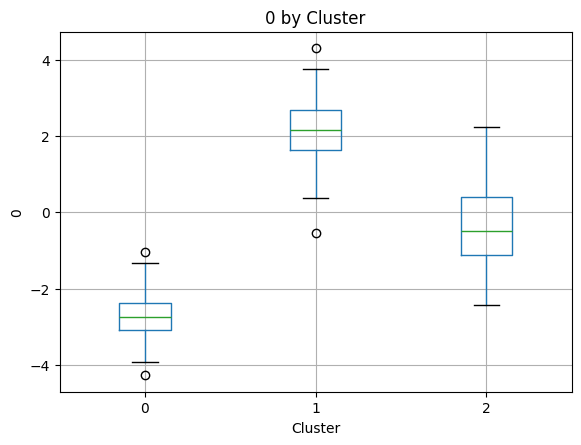

<Figure size 500x400 with 0 Axes>

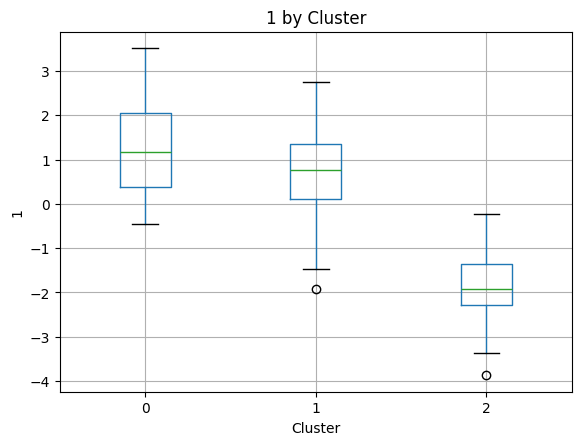

<Figure size 500x400 with 0 Axes>

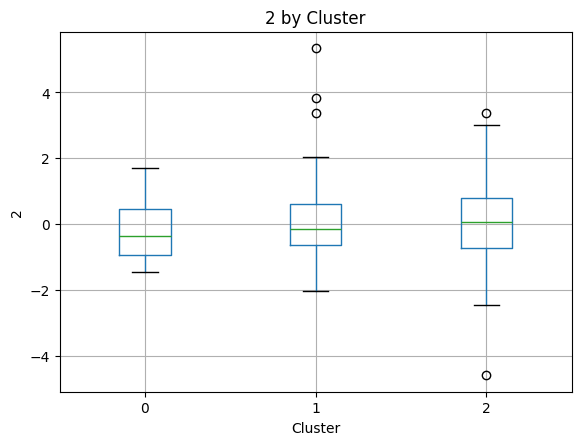

<Figure size 500x400 with 0 Axes>

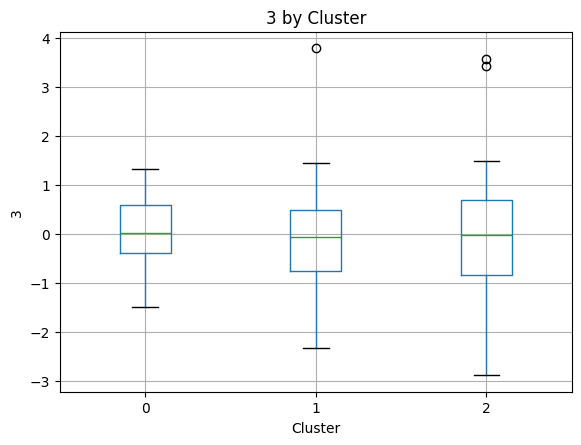

<Figure size 500x400 with 0 Axes>

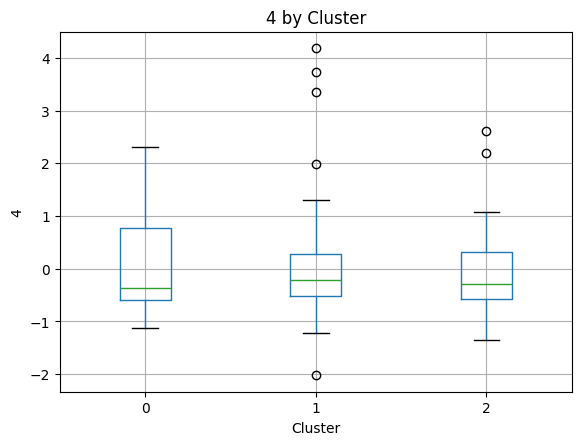

<Figure size 500x400 with 0 Axes>

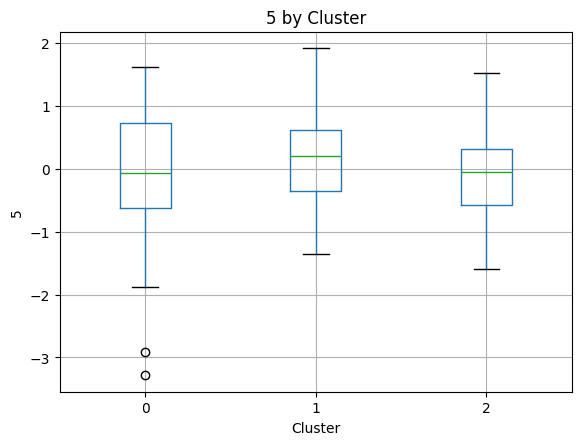

<Figure size 500x400 with 0 Axes>

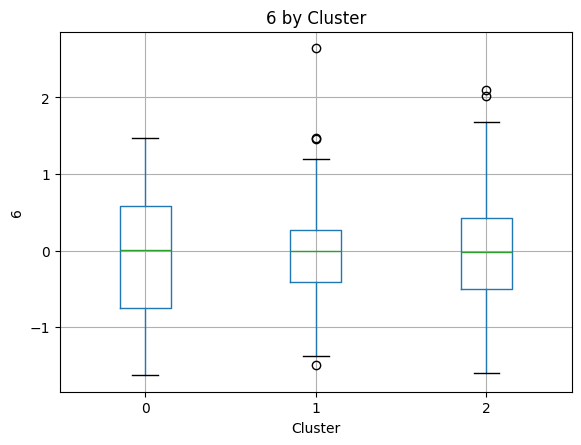

<Figure size 500x400 with 0 Axes>

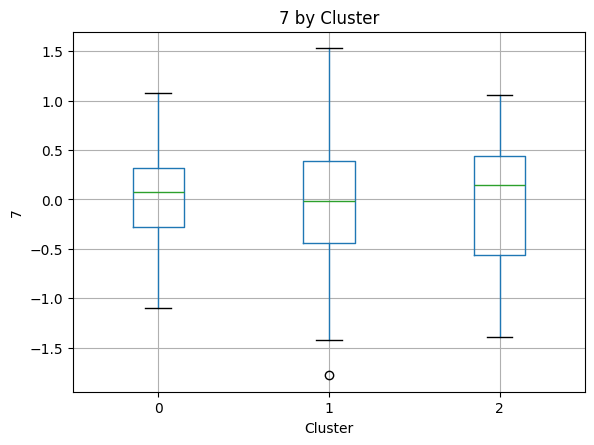

<Figure size 500x400 with 0 Axes>

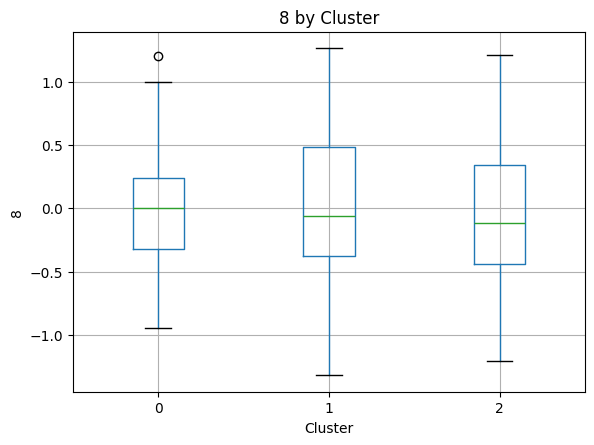

<Figure size 500x400 with 0 Axes>

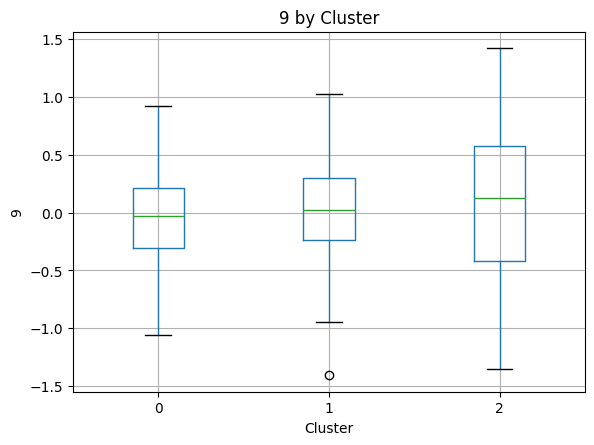

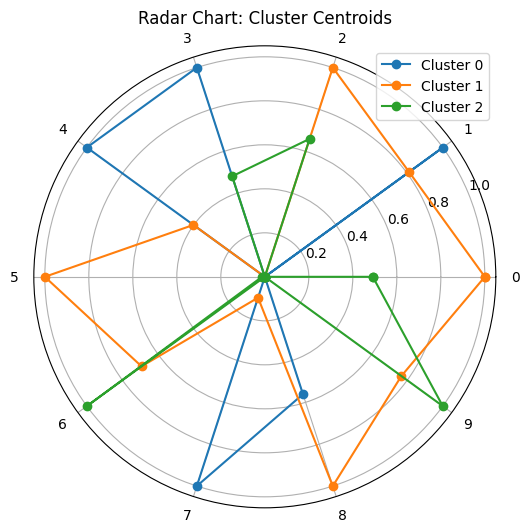

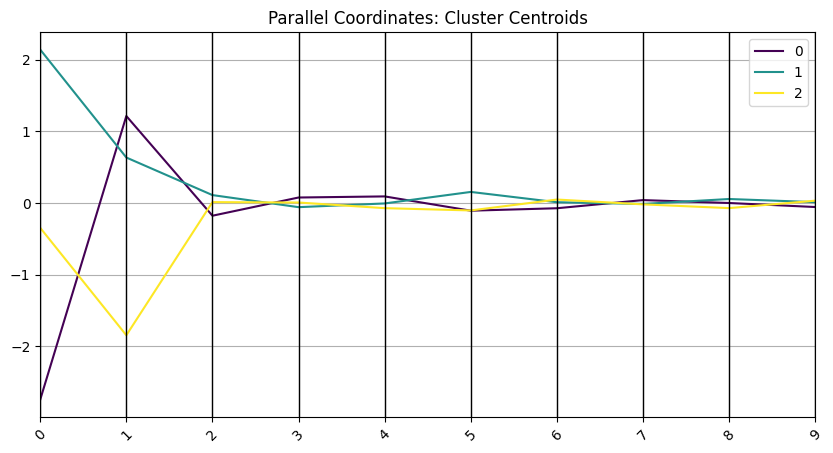


=== KRUSKAL-WALLIS TESTS ===
0: H=146.883, p=0.0000
1: H=109.897, p=0.0000
2: H=1.821, p=0.4024
3: H=1.382, p=0.5010
4: H=0.038, p=0.9812
5: H=3.743, p=0.1539
6: H=0.274, p=0.8722
7: H=0.193, p=0.9079
8: H=1.582, p=0.4533
9: H=1.449, p=0.4847

=== EFFECT SIZE (ETA-SQUARED) ===
0: eta² = 0.8298
1: eta² = 0.6209
2: eta² = 0.0103
3: eta² = 0.0078
4: eta² = 0.0002
5: eta² = 0.0211
6: eta² = 0.0015
7: eta² = 0.0011
8: eta² = 0.0089
9: eta² = 0.0082


0    0.829848
1    0.620888
5    0.021145
2    0.010286
8    0.008940
9    0.008184
3    0.007809
6    0.001545
7    0.001091
4    0.000214
dtype: float64


=== AUTO-SUGGESTED CLUSTER LABELS ===
Cluster 0: 1, 4, 3
Cluster 1: 0, 1, 5
Cluster 2: 6, 9, 2


In [36]:
best_k = int(best_run['k'])
best_init = int(best_run['init_run'])

initial_medoids = random.sample(range(len(X_pca)), best_k)
km_final = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
km_final.process()

clusters_final = km_final.get_clusters()

labels = np.zeros(len(X_pca), dtype=int)
for c_idx, cluster in enumerate(clusters_final):
    labels[cluster] = c_idx

# ------------------------------------------------------------
# Cluster Profiling (based on the PCA features you used in K-Medoids)
# ------------------------------------------------------------

data_clustered = pd.DataFrame(X_pca).copy()
data_clustered["Cluster"] = labels

numeric_features = data_clustered.columns.drop("Cluster")

cluster_profiles = data_clustered.groupby("Cluster").agg(['mean','std','min','max'])
display(cluster_profiles)

profile_table = data_clustered.groupby("Cluster").agg(['mean','std'])
display(profile_table)

# ------------------------------------------------------------
# Feature Distributions by Cluster
# ------------------------------------------------------------
for feature in numeric_features:
    plt.figure(figsize=(5,4))
    data_clustered.boxplot(column=feature, by="Cluster")
    plt.title(f"{feature} by Cluster")
    plt.suptitle("")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.show()

scaler = MinMaxScaler()
centroids = data_clustered.groupby("Cluster")[numeric_features].mean()
centroids_scaled = pd.DataFrame(
    scaler.fit_transform(centroids),
    columns=numeric_features,
    index=centroids.index
)

angles = np.linspace(0, 2*np.pi, len(numeric_features), endpoint=False)
angles = np.concatenate([angles, angles[:1]])

plt.figure(figsize=(6,6))
for c in centroids_scaled.index:
    vals = centroids_scaled.loc[c].values
    vals = np.concatenate([vals, vals[:1]])
    plt.polar(angles, vals, marker='o', label=f"Cluster {c}")
plt.xticks(angles[:-1], numeric_features)
plt.legend()
plt.title("Radar Chart: Cluster Centroids")
plt.show()

temp_pc = centroids.copy()
temp_pc["Cluster"] = temp_pc.index.astype(str)

plt.figure(figsize=(10,5))
parallel_coordinates(temp_pc, "Cluster", colormap="viridis")
plt.xticks(rotation=45)
plt.title("Parallel Coordinates: Cluster Centroids")
plt.show()

# ------------------------------------------------------------
# Statistical Validation (Kruskal–Wallis + Effect Size)
# ------------------------------------------------------------
print("\n=== KRUSKAL-WALLIS TESTS ===")
N = len(data_clustered)
effect_sizes = {}

for feature in numeric_features:
    groups = [data_clustered[data_clustered["Cluster"] == c][feature] 
              for c in range(best_k)]
    stat, p = stats.kruskal(*groups)
    print(f"{feature}: H={stat:.3f}, p={p:.4f}")

    eta_sq = stat / (N - 1)
    effect_sizes[feature] = eta_sq

print("\n=== EFFECT SIZE (ETA-SQUARED) ===")
for feat, eta in effect_sizes.items():
    print(f"{feat}: eta² = {eta:.4f}")

discriminative_rank = pd.Series(effect_sizes).sort_values(ascending=False)
display(discriminative_rank)

# ------------------------------------------------------------
# Auto-Suggest Cluster Names (Top 3 highest-mean features)
# ------------------------------------------------------------
centroids_raw = data_clustered.groupby("Cluster")[numeric_features].mean()

suggested_names = {}
for c in centroids_raw.index:
    desc = centroids_raw.loc[c].sort_values(ascending=False).head(3)
    suggested_names[c] = ", ".join(desc.index.astype(str))

print("\n=== AUTO-SUGGESTED CLUSTER LABELS ===")
for c, name in suggested_names.items():
    print(f"Cluster {c}: {name}")


### Cluster Interpretation Summary

The clustering results reveal three distinct wine profiles based on the PCA-transformed chemical characteristics of the Wine dataset. **Cluster 2** represents full-bodied wines with higher alcohol content, stronger color intensity, and richer flavonoid structure, aligning with a more robust and intense wine style. **Cluster 0** captures wines with comparatively low alcohol and color intensity but elevated phenolic complexity, indicating a profile defined by structural depth rather than strength. **Cluster 1** consists of more balanced, moderate wines with neither strong phenolic expression nor high alcohol characteristics, forming the most chemically central group.

Statistical testing (Kruskal–Wallis) confirms that multiple PCA components differ significantly across clusters, with **PC1 and PC2 showing the strongest effects**, indicating that alcohol content, phenolic compounds, color intensity, and flavonoid structure drive most of the separation. Radar plots, boxplots, and centroid comparisons further support these distinctions, showing clear differences in cluster-level feature patterns. Overall, the model successfully identifies chemically meaningful wine categories that reflect known compositional differences in the dataset.
